In [16]:
# Any import needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import sparse
import joblib
import os

# --- Visualizations ---
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay,
    ConfusionMatrixDisplay, classification_report
)
from sklearn.calibration import CalibrationDisplay



From the models given in logistic_regression_fraud.py, we obtain the following statistics on out created models:

## **Regression on Original Features**

**[RESULTS] Logistic Regression (Lightweight)**  

| Class | Precision | Recall | F1-Score | Support |
|:------|:----------:|:-------:|:---------:|:--------:|
| **0** | 0.9886 | 0.8316 | 0.9033 | 113,975 |
| **1** | 0.1366 | 0.7346 | 0.2304 | 4,133 |
| **Accuracy** |  |  | **0.8283** | 118,108 |
| **Macro Avg** | 0.5626 | 0.7831 | 0.5669 | 118,108 |
| **Weighted Avg** | 0.9587 | 0.8283 | 0.8798 | 118,108 |

**ROC AUC:** `0.8639`  

**Confusion Matrix:**


|               | Predicted 0 | Predicted 1 |
|:--------------|:------------:|:------------:|
| **Actual 0**  | 94787        | 19188        |
| **Actual 1**  | 1097         | 3036         |




---

## **Regression on PCA Features**

**[RESULTS] Logistic Regression on PCA Features**  

| Class | Precision | Recall | F1-Score | Support |
|:------|:----------:|:-------:|:---------:|:--------:|
| **0** | 0.9855 | 0.7598 | 0.8581 | 113,975 |
| **1** | 0.0947 | 0.6925 | 0.1666 | 4,133 |
| **Accuracy** |  |  | **0.7575** | 118,108 |
| **Macro Avg** | 0.5401 | 0.7262 | 0.5123 | 118,108 |
| **Weighted Avg** | 0.9544 | 0.7575 | 0.8339 | 118,108 |

**ROC AUC:** `0.8027`  

**Confusion Matrix**

|               | Predicted 0 | Predicted 1 |
|:--------------|:------------:|:------------:|
| **Actual 0**  | 86602        | 27373        |
| **Actual 1**  | 1271         | 2862         |



From the above statements we are able to learn a lot about how our 2 model preformed. For starters, the ROC AUC is a summary metric, telling us how well our model does in general, amongst the entire training set. From this, we see our model that uses the PCA features generates more error than the model that is trained on the original features. This tells us we need to look further into our PCA algorithm, or maybe that we should not be preforming PCA and each feature in the dataset is valuable.

In [15]:
# Model code from logistic_regression_fraud
SAMPLE_SIZE = None

# ---------- Load and Merge Data ----------
def load_data():
    transaction = pd.read_csv("train_transaction.csv")
    identity = pd.read_csv("train_identity.csv")
    df = transaction.merge(identity, on="TransactionID", how="left")
    return df

def load_data_optimized():
    print("[INFO] Loading data...")
    transaction = pd.read_csv("train_transaction.csv", usecols=lambda c: c != "TransactionDT")
    identity = pd.read_csv("train_identity.csv")
    df = transaction.merge(identity, on="TransactionID", how="left")
    if SAMPLE_SIZE:
        df = df.sample(SAMPLE_SIZE, random_state=42)
        print(f"[INFO] Using sample of {len(df):,} rows")
    return df


def preprocess_data_optimized(df):
    print("[INFO] Preprocessing data...")
    y = df["isFraud"].astype(int)
    X = df.drop(columns=["isFraud"])

    numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

    # Fill missing values
    X[numeric_cols] = X[numeric_cols].fillna(0)
    X[categorical_cols] = X[categorical_cols].fillna("missing")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
        ]
    )

    X_transformed = preprocessor.fit_transform(X)
    print(f"[INFO] Transformed shape: {X_transformed.shape}")
    if not sparse.issparse(X_transformed):
        X_transformed = sparse.csr_matrix(X_transformed)

    return X_transformed, y, preprocessor


def train_logistic_regression_optimized(X, y, model_name="original"):
    print("[INFO] Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("[INFO] Computing class weights...")
    weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), weights))

    print("[INFO] Training Logistic Regression...")
    clf = LogisticRegression(
        max_iter=300,
        solver="saga",
        class_weight=class_weights,
        n_jobs=-1,
        verbose=1
    )
    clf.fit(X_train, y_train)

    print("[INFO] Evaluating model...")
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(f"\n[RESULTS] Logistic Regression ({model_name})")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    os.makedirs("models", exist_ok=True)
    joblib.dump(clf, f"models/logreg_{model_name}.pkl")
    print(f"[SAVED] Model saved as models/logreg_{model_name}.pkl")

    return y_pred, y_prob, X_train, X_test, y_train, y_test


# ---------- Run Logistic Regression on PCA features ----------
def run_pca_logreg():
    # Load PCA data
    pca_df = pd.read_csv("pca_features.csv")
    original = load_data()
    y = original["isFraud"].astype(int)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        pca_df, y, test_size=0.2, random_state=42, stratify=y
    )

    weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), weights))

    clf = LogisticRegression(
        max_iter=300,
        solver="lbfgs",
        class_weight=class_weights,
        n_jobs=-1,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    print(f"\n[RESULTS] Logistic Regression on PCA features")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    joblib.dump(clf, "models/logreg_pca.pkl")

    return y_pred, y_prob, X_train, X_test, y_train, y_test


# --- Main ---
print("[INFO] Loading and preprocessing original dataset...")
df = load_data_optimized()
X, y, preprocessor = preprocess_data_optimized(df)

print("[INFO] Training logistic regression on original features...")
opt_pred, opt_prob, opt_x_train, opt_x_test, opt_y_train, opt_y_test = train_logistic_regression_optimized(X, y, model_name="lightweight")

print("[INFO] Training logistic regression on PCA features...")
pca_pred, pca_prob, pca_x_train, pca_x_test, pca_y_train, pca_y_test = run_pca_logreg()

[INFO] Loading and preprocessing original dataset...
[INFO] Loading data...
[INFO] Preprocessing data...
[INFO] Transformed shape: (590540, 2863)
[INFO] Training logistic regression on original features...
[INFO] Splitting data...
[INFO] Computing class weights...
[INFO] Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.24659188
Epoch 3, change: 0.139044
Epoch 4, change: 0.11311844
Epoch 5, change: 0.097011118
Epoch 6, change: 0.086278151
Epoch 7, change: 0.078422178
Epoch 8, change: 0.071135341
Epoch 9, change: 0.065252643
Epoch 10, change: 0.060464534
Epoch 11, change: 0.055586995
Epoch 12, change: 0.051496206
Epoch 13, change: 0.046401412
Epoch 14, change: 0.042633411
Epoch 15, change: 0.039659434
Epoch 16, change: 0.037402538
Epoch 17, change: 0.035484113
Epoch 18, change: 0.033733042
Epoch 19, change: 0.032115927
Epoch 20, change: 0.030705891
Epoch 21, change: 0.029359514
Epoch 22, change: 0.028191157
Epoch 23, change: 0.027075612
Epoch 24, change: 0.026044652
Epoch 25, change: 0.025097065
Epoch 26, change: 0.024242772
Epoch 27, change: 0.023396854
Epoch 28, change: 0.022649994
Epoch 29, change: 0.021908769
Epoch 30, change: 0.021242476
Epoch 31, change: 0.020620657
Epoch 32, change: 0.02002059
Epoch 33, change: 0.0194522
Epoch 34, change: 0.01891242
Epoch 35

/opt/anaconda3/envs/ml-hw3/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
python(29383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29385) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29386) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29387) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29391) MallocStack


[RESULTS] Logistic Regression on PCA features
              precision    recall  f1-score   support

           0     0.9855    0.7598    0.8581    113975
           1     0.0947    0.6925    0.1666      4133

    accuracy                         0.7575    118108
   macro avg     0.5401    0.7262    0.5123    118108
weighted avg     0.9544    0.7575    0.8339    118108

ROC AUC: 0.8027488677498615
Confusion Matrix:
 [[86602 27373]
 [ 1271  2862]]


Now that I have the above data and results from the logistic_regression_frad, I can make visualization for the data. Starting with confusion matrices I get:

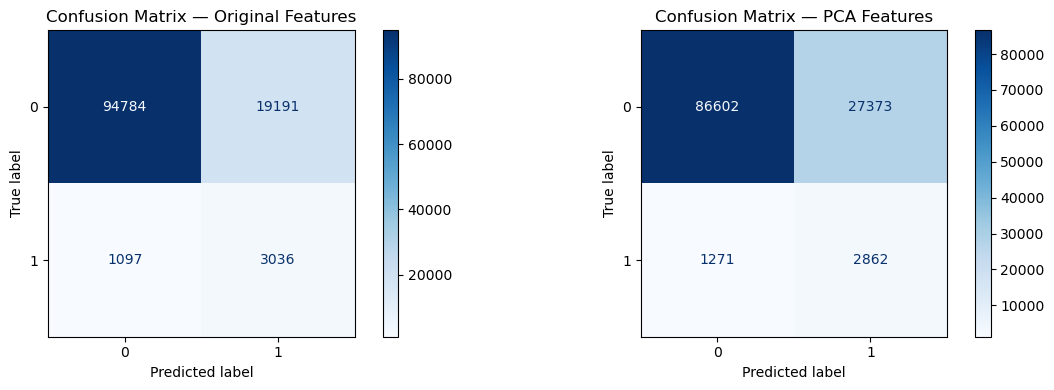

In [18]:
# ---- Generate Confusion Matrices For Each Model ----

fig, axes = plt.subplots(1, 2, figsize=(12,4))

ConfusionMatrixDisplay.from_predictions(
    opt_y_test, opt_pred, cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion Matrix — Original Features")

ConfusionMatrixDisplay.from_predictions(
    pca_y_test, pca_pred, cmap="Blues", ax=axes[1]
)
axes[1].set_title("Confusion Matrix — PCA Features")

plt.tight_layout()
plt.show()


The above graphs show a confusion matrix of both models, showing how the model predicted fraudulent and nonfraudulent transactions. For the majority of data points, the model behaved well, producing the most true negatives. However, out of roughly 118,000 transactions, the model let 1,097 and 1,271 fraudulent transactions through for the model that used the original features and our PCA features, respectively. This equates to roughly 0.01% of all of our transactions making it past our model and turn out to be fraudulent. Depending on the real world implications, or company we decided to work with for this problem, we could tweak this number to better serve client needs.  

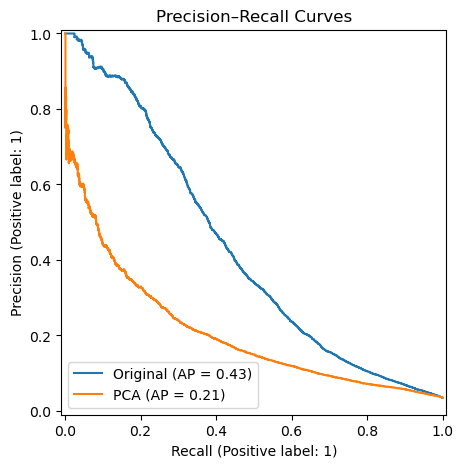

In [19]:
# ---- Precision and Recall Curves ----
fig, ax = plt.subplots(figsize=(6,5))

PrecisionRecallDisplay.from_predictions(opt_y_test, opt_prob, name="Original", ax=ax)
PrecisionRecallDisplay.from_predictions(pca_y_test, pca_prob, name="PCA", ax=ax)

ax.set_title("Precision–Recall Curves")
plt.show()


The above graph is a precision recall curve, plotting the recall values (fraction of actual fraudulent transactions being detected) against the precision values (fraction of predicted frauds that are truly fraud). It shows what the precision values are for all of the different recall values. The AP value stands for average precision, which is mathematically calculated as the area under the curve, but conceptually it represents how precise our model is, while we try to catch more and more fraudulent transactions. The lower AP in our PCA curve tells us that when we try to increase the number of fraudulent transactions caught, this will also increase the number of false positives, which in our scenario could be very costly. A transaction labeled as fraud when it is not, could result in many unhappy customers, frustrated that their transactions are not going through.

The graph above is going to be very helpful in helping us continue to check the number of false positives as we continue to increase the number of fraudulent transactions flagged. As we continue to tweak our model, we will continue to review this chart, and hope to improve our AP scores. An AP score of 0.43 on our orignial model is not terrible given the dataset and the small number of fraudulent transactions we have to work with, yet we still want to improve that number to around 0.6. 

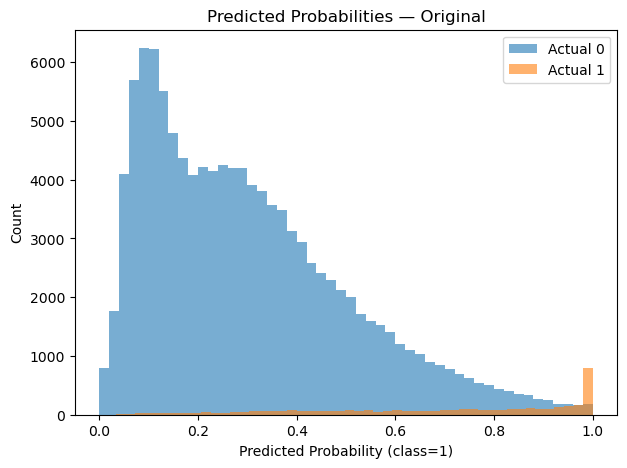

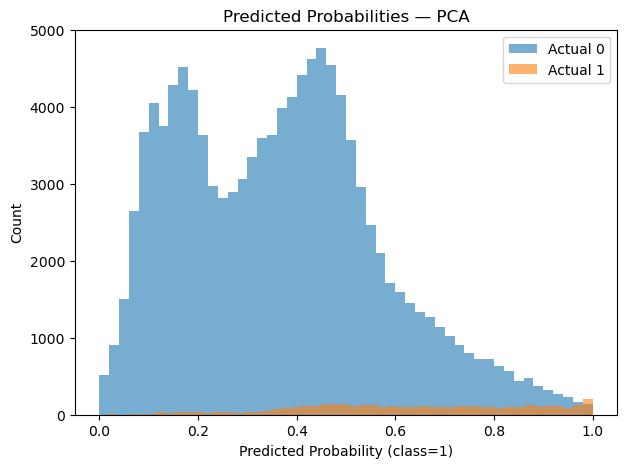

In [21]:
# --- Probability Distributions ---

def plot_prob_hist(y_true, y_score, title):
    plt.figure(figsize=(7,5))
    plt.hist(y_score[np.array(y_true)==0], bins=50, alpha=0.6, label="Actual 0")
    plt.hist(y_score[np.array(y_true)==1], bins=50, alpha=0.6, label="Actual 1")
    plt.xlabel("Predicted Probability (class=1)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()

plot_prob_hist(opt_y_test, opt_prob, "Predicted Probabilities — Original")
plot_prob_hist(pca_y_test, pca_prob, "Predicted Probabilities — PCA")


The above chart is a historgram, showing the distribution of fraudulent and non fraudulent transactions in the dataset, as well as their predicted probability of how likley the transaction was fraudulent. Given the above graph we first see the count in true fraudulent transactions arise around a probability of 0.1, and increase around 0.4. For our first logistic regression model, we chose a simple threshold of 0.5 to determine what transactions would be classified as fraudulent or not. In a real world scenario, we would likely lower that threshold as we want less fraud to be getting through our model. Fraudulent transactions result in huge losses to customers, so it would be better for a bank or financial institution to flag more activity as fraud in order to avoid as much fraud as possible. 

## Analysis

Given the above visualization on our model, our model provides adequate results to generate a baseline result for predicting fraudulent transactions or not. By using our threshold of 0.50 on our logistic regression model, almost a quarter of the fraudulent transactions are getting through our model and labeled as not fraud. This is definelty an area of our model that needs improvement. While the dataset only has around 4,000 fraudulent transactions available to us to train on, we still wish to stop more fraudulent transactions, and plan to work on this throughout the semester. 

## Next Steps

Given the state of our model, there are a few steps we can take to look to improve our model. For starters, as mentioned previously we selected a simple 50% threshold to classify a transaction as fraud. While for most scenarios this may be the best value to choose, for this scenario we may want to lower the threshold to classify more variables as fraudulent. Most banks and financial institutions want to ensure they stop as much fraud as possible. For our model, this may come at the cost of mislabeling transactions as fraudulent when they are not, but as a whole we would get fewer false negatives, and would save bank customers lots of money and stress from being fraud victims. Aside from the threshold, we can reexamine our PCA analysis, as the overall accuracy of the model decreased by training on PCA. While this is typical in PCA, we will expierement with getting more features from PCA, and seeing how our accuracy changes. Given we are just running the model locally, we can test adding more PCA features, even though it will increase the model's execution power. 

As a team, we can also do research into features are needed to improve our commercial level fraud detection model. These are models that have become extremely common with the surge in machine learning over the past few years, and can help us learn how to improve our model. 